In [1]:
import numpy as np
import torch
from glob import glob
from tqdm import tqdm_notebook as tqdm
import torchvision
from matplotlib import pyplot as plt

In [181]:
mnist = torchvision.datasets.MNIST("./", download=True, transform=torchvision.transforms.ToTensor())
sampler = torch.utils.data.dataloader.DataLoader(mnist, batch_size=100, shuffle=True)

In [182]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
class segnet(torch.nn.Module):
    
    def __conv__(self, in_channels, out_channels, stride, kernel_size, padding=(0, 0)):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU()
        )
    
    def __convt__(self, in_channels, out_channels, stride, kernel_size, padding=(0, 0)):
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, stride=stride, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU()
        )
    
    
    def __encoder__(self):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU()
        )
    
    def __reparamaterize__(self, mean, sigma):
        return torch.randn(mean.shape) * torch.exp(sigma/2) + mean
    
    def __decoder__(self):
        return torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=64, stride=2, kernel_size=4, padding=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=4, padding=0),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=1, kernel_size=3, padding=0),
        )


    def __init__(self):
        super(segnet, self).__init__()
        self.encoder = self.__encoder__()
        self.decoder = self.__decoder__()
        self.enc_linear = torch.nn.Linear(in_features=64*6*6, out_features=128)
        self.dec_linear = torch.nn.Linear(in_features=64, out_features=7*7*32)
  

    def forward(self, x):
        latent_var = self.encoder(x).reshape([-1, 64*6*6])
        latent_var = self.enc_linear(latent_var).reshape([-1, 2, 64])
        latent_var_re = self.__reparamaterize__(latent_var[:,0], latent_var[:,1])
        decoded_linear = self.dec_linear(latent_var_re).reshape([-1, 32, 7, 7])
        return {
            "output": self.decoder(decoded_linear),
            "latent" : latent_var_re,
            "encoder": latent_var
        }
        

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [186]:
segnet_model = segnet().to(device)

In [187]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = np.log(2. * np.pi)
    
    return torch.sum(-.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi))

In [188]:
import torch.optim as optim

criterion = torch.nn.BCEWithLogitsLoss(reduction="sum")
l1_loss = torch.nn.L1Loss()
optimizer = optim.Adagrad(segnet_model.parameters(), lr=0.001)

In [189]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

task_type = "Question1lstm"
time_date = "{}".format(datetime.now())
tensorboard_writer = SummaryWriter("log/{}/{}".format(task_type, time_date))

In [ ]:
# batch_size = 8
plots = []
running_loss = 0.
controller = tqdm(total=16*619)

best_val_loss = 0
for epoch in range(0 ,1000):
    train_loss = []
    train_acc = []
    for each_batch_sample in sampler:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        input_sample = each_batch_sample[0].to(device)
        batch_size = input_sample.shape[0]
        outputs = segnet_model(input_sample)
        
        loss = criterion(outputs['output'], input_sample)
        vl = log_normal_pdf(outputs['latent'], torch.Tensor([0]*64), torch.Tensor([0]*64)) - log_normal_pdf(outputs['latent'], outputs['encoder'][:,0], outputs['encoder'][:,1])
        loss -= vl
        loss /= batch_size
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        tensorboard_writer.add_scalar("loss/batch/train", loss.item(), controller.n)
        train_loss.append(loss.item())
        
    if epoch%50 == 49:
        tensorboard_writer.add_scalar("loss/epoch/train", np.mean(train_loss), epoch)
        val_loss = []

        for each_val_sample in sampler:
            input_sample = each_val_sample[0].to(device)
            outputs = segnet_model(input_sample)
            loss = criterion(outputs['output'], input_sample)
            vl = log_normal_pdf(outputs['latent'], torch.Tensor([0]*64), torch.Tensor([0]*64)) - log_normal_pdf(outputs['latent'], outputs['encoder'][:,0], outputs['encoder'][:,1])
            loss -= vl
            val_loss.append(loss.item())

        tensorboard_writer.add_scalar("loss/epoch/val", np.mean(val_loss), epoch)

        if np.mean(val_loss) > best_val_loss:
            torch.save(segnet_model.state_dict(), "./weights/question_1_lstm{}".format(epoch))
            best_val_loss = np.mean(val_loss)
    controller.update()
print('Finished Training')

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [208]:
output = torch.sigmoid(segnet_model(samples[0].to(device))['output']).detach().cpu().numpy()

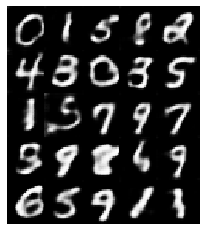

In [209]:
_, ax = plt.subplots(nrows=5, ncols=5)
for i, e in enumerate(ax):
    for j, k in enumerate(e):
        k.imshow(output[i*5+j][0], cmap="gray")
        k.axis('off')
plt.subplots_adjust(wspace=-0.8, hspace=0)

In [176]:
samples[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [106]:
vae_space = []
vae_output = []
for each_batch_sample in tqdm(sampler):
    encoded = segnet_model.encoder(each_batch_sample[0].to(device)).reshape([-1, 64*6*6])
    latent_var = segnet_model.enc_linear(encoded).reshape([-1, 2, 64])
    vae_space.append(segnet_model.__reparamaterize__(latent_var[:,0], latent_var[:,1]).detach().cpu().numpy())
    vae_output.append(each_batch_sample[1].cpu().numpy())

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
vae_output = np.concatenate(vae_output, axis=0)
vae_space = np.concatenate(vae_space, axis=0)

In [40]:
from sklearn.manifold import TSNE

In [73]:
tsne = TSNE()

In [74]:
tsne_output = tsne.fit_transform(vae_space[:10000])

In [75]:
vae_space.shape

(10000, 64)

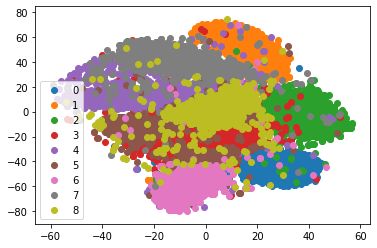

In [76]:
for k in range(9):
    plt.scatter(tsne_output[vae_output[:10000]==k][:,0],tsne_output[vae_output[:10000]==k][:,1], label=k)
plt.legend()

In [14]:
encoded.shape

torch.Size([100, 2304])

In [52]:
from sklearn.svm import SVC

In [54]:
svc = SVC(verbose=3)

In [55]:
svc.fit(vae_space, vae_output)

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=3)

In [108]:
output = svc.predict(vae_space)

In [109]:
np.count_nonzero(output == vae_output)/len(vae_output)

0.9550666666666666

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [80]:
confused = confusion_matrix(y_pred=output, y_true=vae_output)

In [113]:
np.mean(recall_score(y_pred=output, y_true=vae_output, average=None))

0.9546562707920321

In [100]:
np.mean(precision)

0.9525145584612174

In [112]:
np.mean(f1_score(y_pred=output, y_true=vae_output, average=None))

0.9547205546744658

In [87]:
import pandas as pd
pdd = pd.DataFrame(confused)

In [92]:
print(pdd.to_markdown())

|    |   0 |    1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|----:|-----:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 964 |    0 |   1 |   2 |   0 |   4 |   6 |   1 |   2 |   0 |
|  1 |   0 | 1124 |   4 |   1 |   0 |   0 |   1 |   0 |   4 |   1 |
|  2 |   5 |    4 | 983 |   7 |   1 |   1 |   2 |  11 |  17 |   1 |
|  3 |   2 |    1 |  13 | 941 |   1 |  17 |   1 |   9 |  21 |   4 |
|  4 |   2 |    1 |   4 |   0 | 926 |   1 |   4 |   3 |   4 |  37 |
|  5 |   3 |    1 |   0 |  17 |   2 | 842 |   5 |   3 |  16 |   3 |
|  6 |   6 |    3 |   2 |   0 |   3 |   5 | 935 |   0 |   4 |   0 |
|  7 |   0 |    9 |  15 |   1 |   8 |   0 |   0 | 971 |   1 |  23 |
|  8 |   2 |    3 |   8 |  13 |   9 |  13 |   6 |   3 | 911 |   6 |
|  9 |   5 |    8 |   1 |   8 |  25 |   4 |   0 |  15 |  12 | 931 |


In [90]:
!pip3 install tabulate --user

  Using cached https://files.pythonhosted.org/packages/c4/f4/770ae9385990f5a19a91431163d262182d3203662ea2b5739d0fcfc080f1/tabulate-0.8.7-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
torch.save(segnet_model.state_dict(), "./builds/question_1_lstm_1".format(epoch))

FileNotFoundError: [Errno 2] No such file or directory: './builds/question_1_lstm_1'

In [0]:
outputs.shape

In [0]:
segnet_model(each_batch_sample['input'].to(device).long())[-1]

In [0]:
one_hot = np.eye(4)

In [0]:
segnet_model.load_state_dict(torch.load("./weights/vgg_again_38"))

In [0]:
test_dataset = BrainDataset(glob("processed_data/test/*.npz"))

In [0]:
zero_output = []
zero_gt = []
output_dice = []
for index, e in tqdm(enumerate(test_dataset)):
    
    output = torch.nn.functional.softmax(segnet_model(e['input'].to(device))).cpu().detach().numpy()
    output = np.argmax(output, axis=1)
    
    output_one_hot = one_hot[output]
    gt_one_hot = one_hot[e['gt']]
    nonzero_output = np.count_nonzero(output_one_hot, axis=(1, 2))
    nonezero_gt = np.count_nonzero(gt_one_hot, axis=(1, 2))
    dice_coeff = 2*np.count_nonzero((output_one_hot*gt_one_hot), axis=(1, 2))/(nonzero_output + nonezero_gt)
    output_dice.append(dice_coeff)

In [0]:
dice_coeff = np.concatenate(output_dice, axis=0)

In [0]:
checkup =  np.nan_to_num(dice_coeff)

In [0]:
np.sum(checkup, axis=0) / np.count_nonzero(checkup, axis=0)

In [0]:
plt.bar(np.arange(4), np.sum(checkup, axis=0) / np.count_nonzero(checkup, axis=0))

In [0]:
plot_sample = test_dataset[0]['input']
plt.imshow(plot_sample[0][0])
plt.axis("off")
output = np.argmax(torch.nn.functional.softmax(segnet_model(plot_sample.to(device))).cpu().detach().numpy()[0], axis=0)
plt.show()
plt.imshow(output)
plt.axis("off")

In [0]:
plt.imshow(output==2)

In [0]:
plt.imshow(output[40:50, 120:150])

In [0]:
output[40:50, 120:150]